<a href="https://colab.research.google.com/github/rochajunior30/PadariaOnDAO/blob/main/Pratica_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Usando algoritmos de Visão Computacional para detecção e contagem de plantas

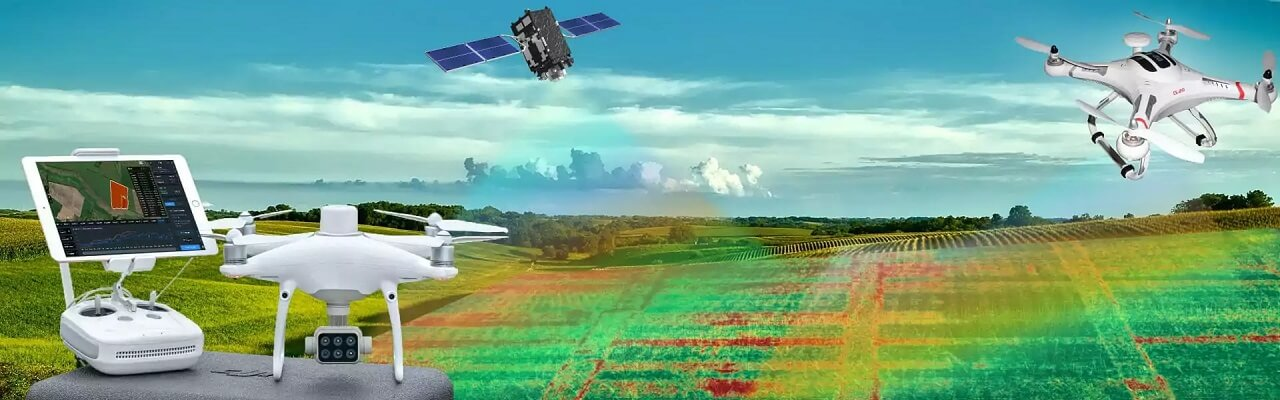

As operações morfológicas são técnicas amplamente utilizadas no processamento de imagens para a detecção e contagem de objetos, incluindo plantas em imagens de drones. Aqui está uma abordagem geral de como você pode usar as operações morfológicas para essa finalidade:

- Pré-processamento da imagem: Antes de aplicar as operações morfológicas, é recomendado realizar etapas de pré-processamento na imagem para melhorar a qualidade dos resultados. Isso pode incluir a redução de ruído com um filtro de suavização, como o filtro gaussiano, e a segmentação da imagem para destacar as regiões de interesse, como as plantas.

- Binarização da imagem: A binarização é o processo de converter a imagem em uma imagem em preto e branco, onde os objetos de interesse são representados como pixels brancos e o fundo como pixels pretos. Existem diferentes métodos de binarização disponíveis, como o método de Otsu ou a aplicação de um limiar fixo. O método escolhido dependerá das características da imagem.

- Operações morfológicas: As duas operações morfológicas mais comumente usadas para detecção e contagem de plantas são a erosão e a dilatação.

    - Erosão: A erosão é usada para remover pequenos detalhes e ruídos da imagem binária. Ela desgasta as bordas dos objetos, diminuindo seu tamanho. Ao aplicar a erosão, os objetos pequenos, como pequenas manchas ou ruídos, desaparecem, enquanto os objetos maiores, como as plantas, são preservados.

    - Dilatação: A dilatação é usada para preencher buracos e aumentar o tamanho dos objetos na imagem binária. Ela expande as bordas dos objetos, tornando-os maiores. Ao aplicar a dilatação, os objetos se tornam mais coesos e conectados.

    - Essas operações podem ser aplicadas em sequência para aprimorar a segmentação das plantas. A ordem da aplicação pode variar dependendo da imagem e do resultado desejado. É possível realizar múltiplas iterações de erosão e dilatação para alcançar o resultado desejado.

- Detecção e contagem de plantas: Após a aplicação das operações morfológicas, você pode identificar as regiões de interesse que correspondem às plantas na imagem binária resultante. Existem várias abordagens que você pode seguir para detectar e contar as plantas:

- Componentes conectados: Usando algoritmos de rotulagem de componentes conectados, é possível identificar regiões conectadas de pixels brancos na imagem binária. Cada região identificada representa uma planta.

- Contagem de objetos: Você pode usar algoritmos de contagem de objetos para identificar e contar os objetos detectados na imagem binária. Esses algoritmos podem contar o número de regiões ou segmentos na imagem, cada um representando uma planta.

Lembre-se de ajustar os parâmetros das operações morfológicas, como o tamanho do elemento estruturante usado na erosão e dilatação, para adaptá-los ao tamanho e forma das plantas que você está procurando detectar.

Link para a imagem: https://drive.google.com/file/d/1Dqp2cJQwvUcGP1ztkJN6jzydBTZdXRwg/view?usp=drive_link

Vamos iniciar instalando o geopandas e o rasterio.

In [ ]:
!pip install geopandas
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 45.1 MB/s eta 0:00:00


Agora, vamos conectar o Drive para acessar os arquivos que serão utilizados:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Instalamos as bibliotecas que vamos usar

In [ ]:
import geopandas as gpd
import numpy as np
import pandas as pd
import shapely
import math
import os
import rasterio
from rasterio.mask import mask
import json
from rasterio.plot import show
import matplotlib.pyplot as plt
import cv2

Então setamos o caminho da imagem que vamos usar:

In [ ]:
path_img = '/content/drive/MyDrive/Datasets/Rice Detection/test_img.tif'

Com o rasterio abrimos a imagem e plotamos com o matplotlib:

In [ ]:
src = rasterio.open(path_img)

In [ ]:
img = src.read()

In [ ]:
img.shape

(4, 741, 1230)

In [ ]:
img = img.transpose([1,2,0])

In [ ]:
img.shape

(741, 1230, 4)

In [ ]:
img = img.astype('uint8')

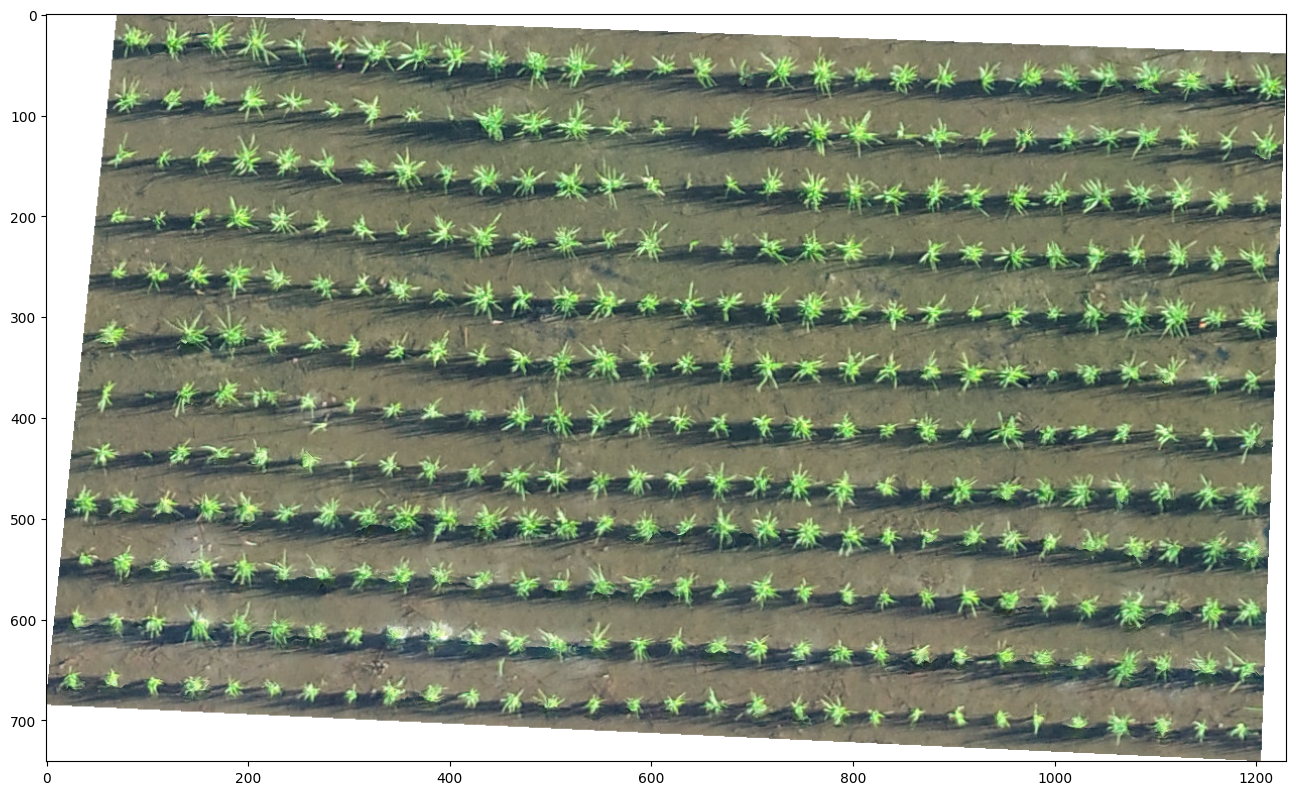

In [ ]:
plt.figure(figsize=[16,16])
plt.imshow(img)

Na nossa imagem RGB vamos separar as bandas espectrais nos canais R,G,B.

In [ ]:
R = img[:,:,0]
G = img[:,:,1]
B = img[:,:,2]

E plotar somente o canal G, com um mapa de cor 'RdYlGn':

(-0.5, 1229.5, 740.5, -0.5)

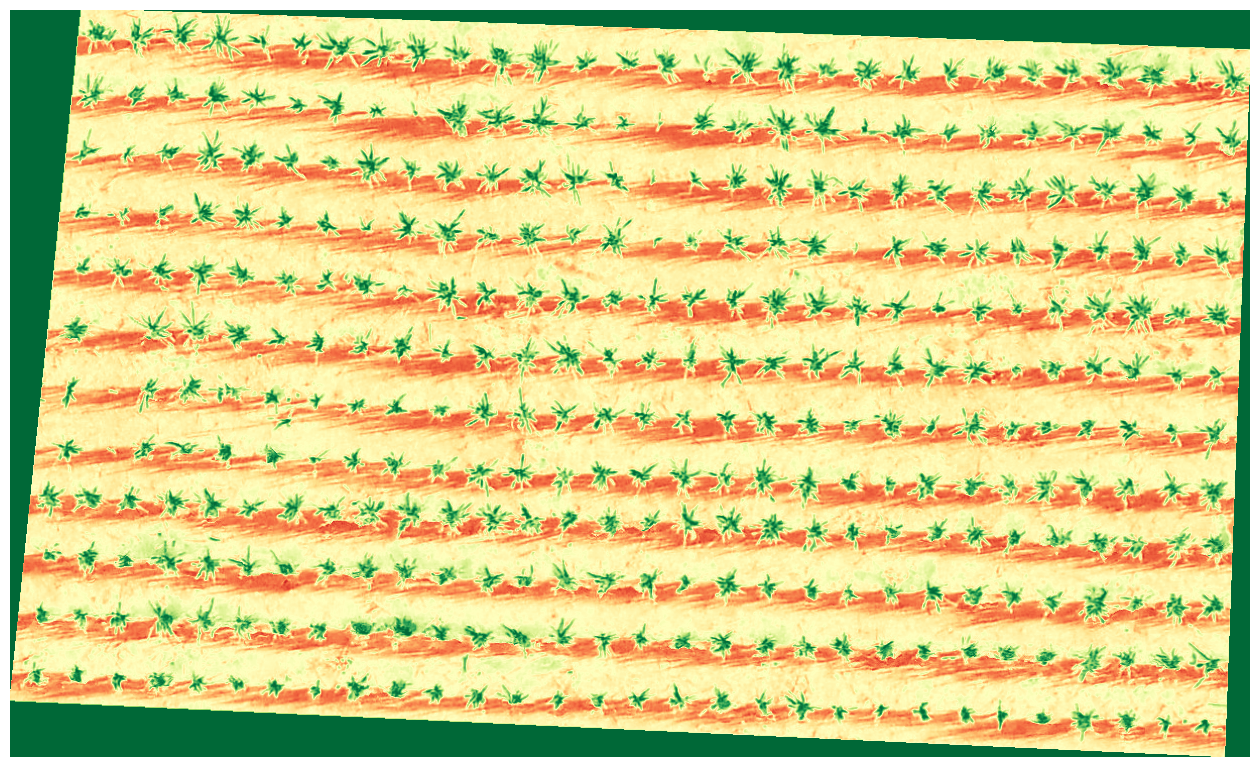

In [ ]:
plt.figure(figsize=[16,16])
plt.imshow(G,cmap='RdYlGn')
plt.axis('off')

Vamos usar esse canal para realizar a binarização da imagem. Antes, vamos converter os valores de bordas que estão em 255 para 0.

In [ ]:
G = np.where(G == 255,0,G)

Para binarizar a imagem, vamos usar o algoritmo de otsu.

In [ ]:
from skimage.filters import threshold_multiotsu

In [ ]:
thresh = threshold_multiotsu(G)

In [ ]:
thresh

array([ 80, 162])

A partir do valor encontrado, vamos usá-lo como limiar para binarizar a imagem:

In [ ]:
binary = G > thresh[1]

(-0.5, 1229.5, 740.5, -0.5)

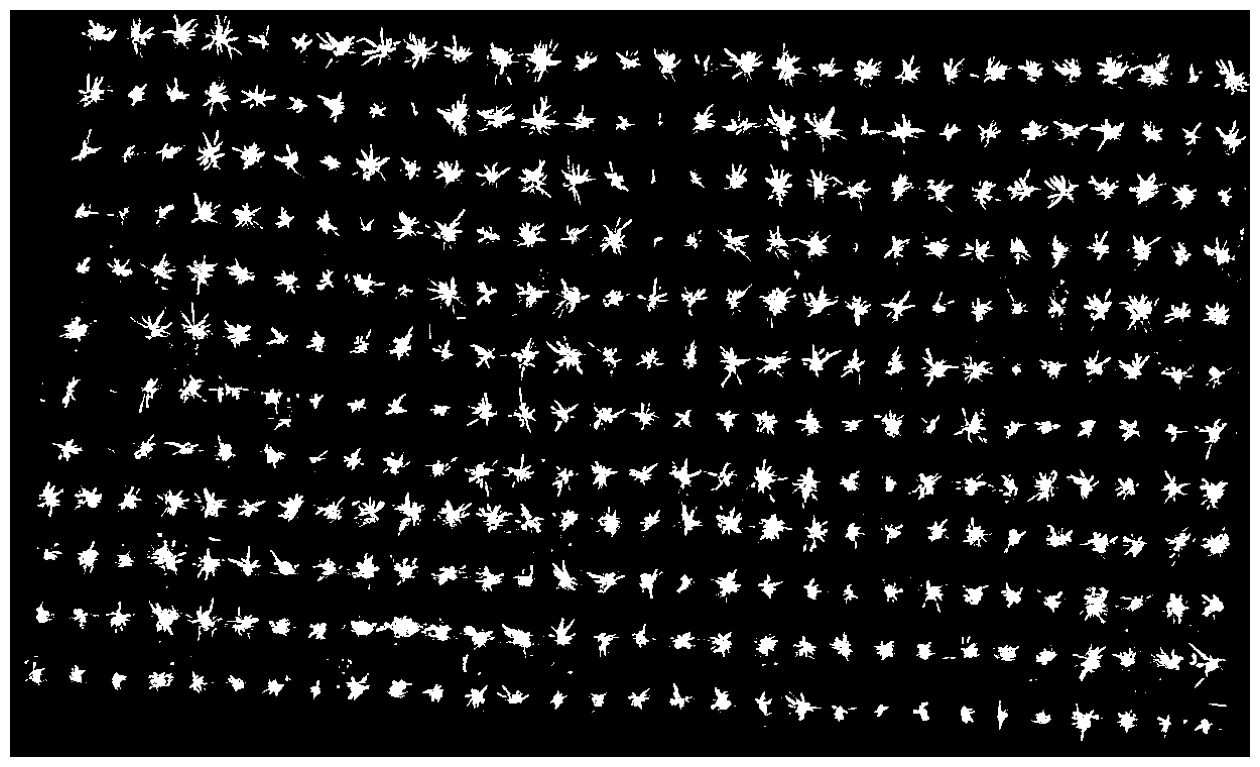

In [ ]:
plt.figure(figsize=[16,16])
plt.imshow(binary,cmap=plt.cm.gray)
plt.axis('off')

Com a imagem binarizada, vamos aplicar operações de erosão e dilatação para remover ruídos e criar áreas mais concisas.

In [ ]:
binary = binary.astype('uint8')

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))

horizontal = cv2.dilate(binary, kernel, iterations = 3)
horizontal = cv2.erode(horizontal, kernel,  iterations = 6)
horizontal = cv2.dilate(horizontal, kernel, iterations = 4)
horizontal = cv2.erode(horizontal, kernel,  iterations = 6)


(-0.5, 1229.5, 740.5, -0.5)

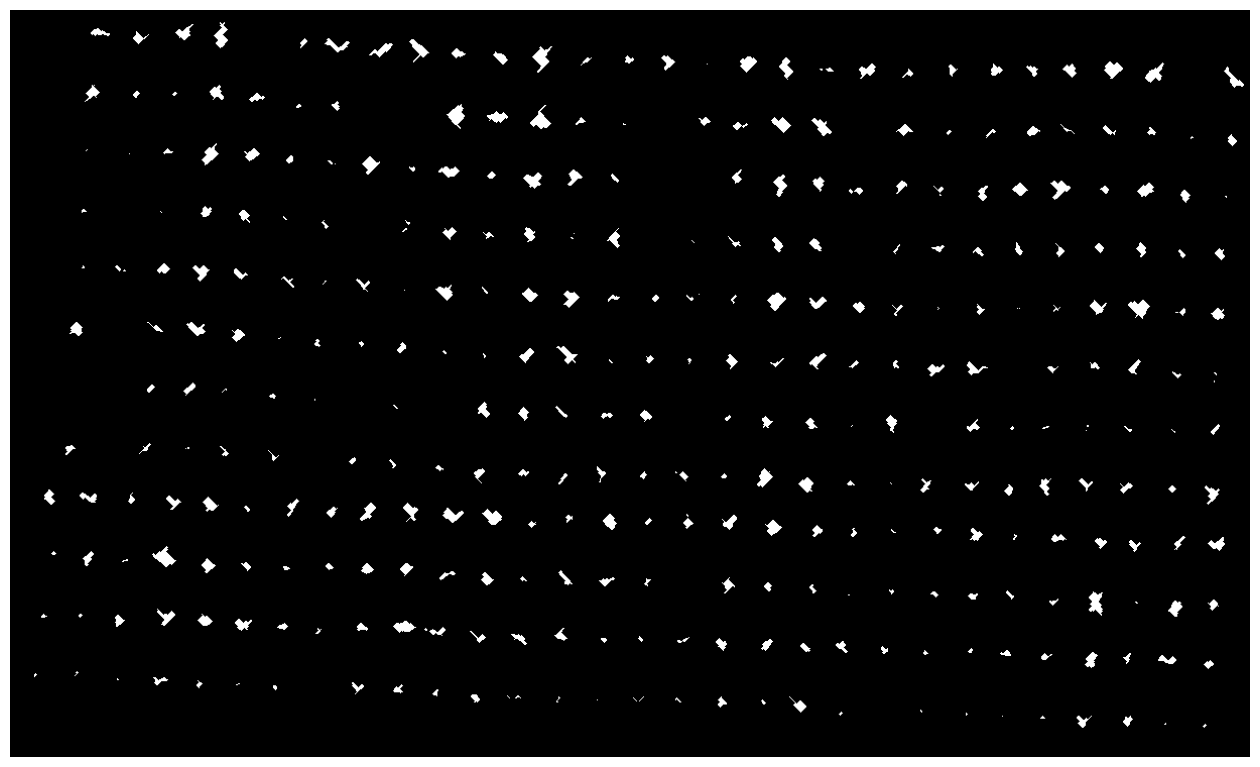

In [ ]:
plt.figure(figsize=[16,16])
plt.imshow(horizontal,cmap=plt.cm.gray)
plt.axis('off')

A próxima etapa é obter cada componenta da imagem e obter a contagem:

In [ ]:
num_labels, labels_im = cv2.connectedComponents(horizontal)

In [ ]:
num_labels

346

(-0.5, 1229.5, 740.5, -0.5)

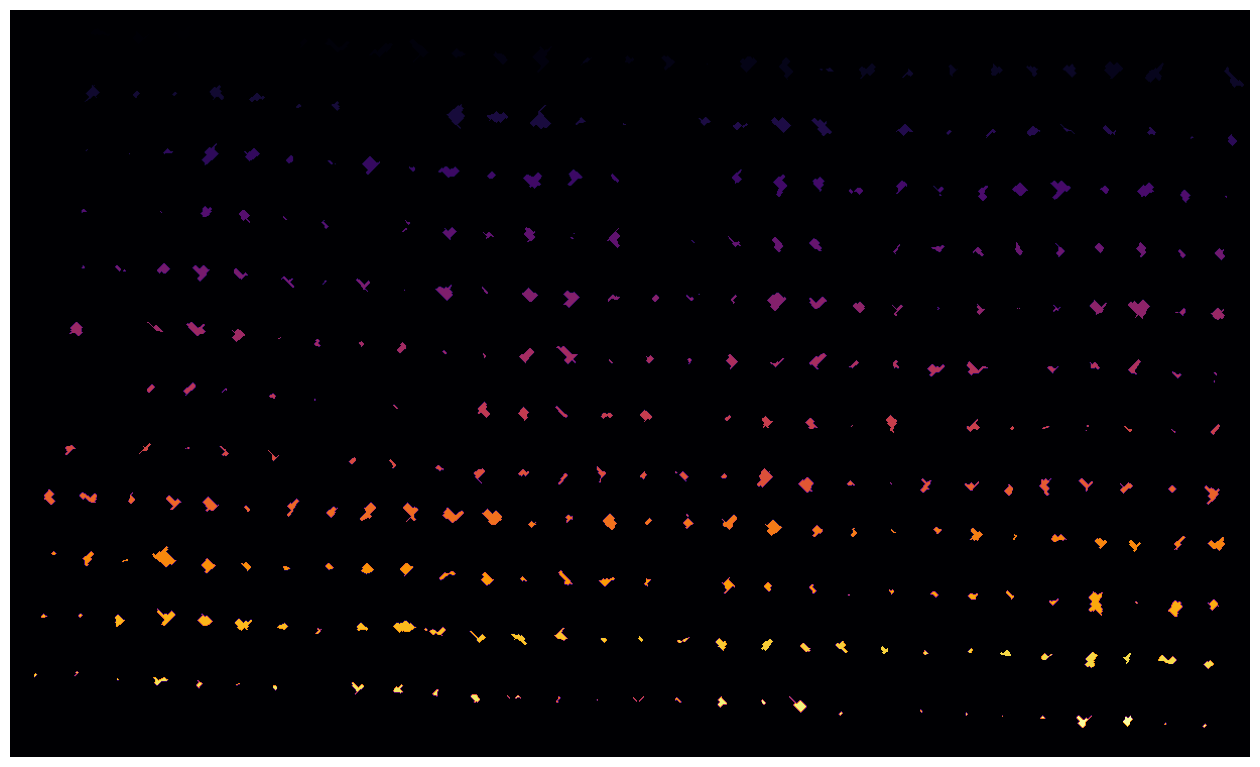

In [ ]:
plt.figure(figsize=[16,16])
plt.imshow(labels_im,cmap='inferno')
plt.axis('off')

Assim, podemos obter a localização de cada objeto na imagem. Vamos plotar o boundbox de cada objeto:

In [ ]:
import matplotlib.patches as mpatches

from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

In [ ]:
label_image = label(horizontal)

In [ ]:
img = img[:,:,0:3]

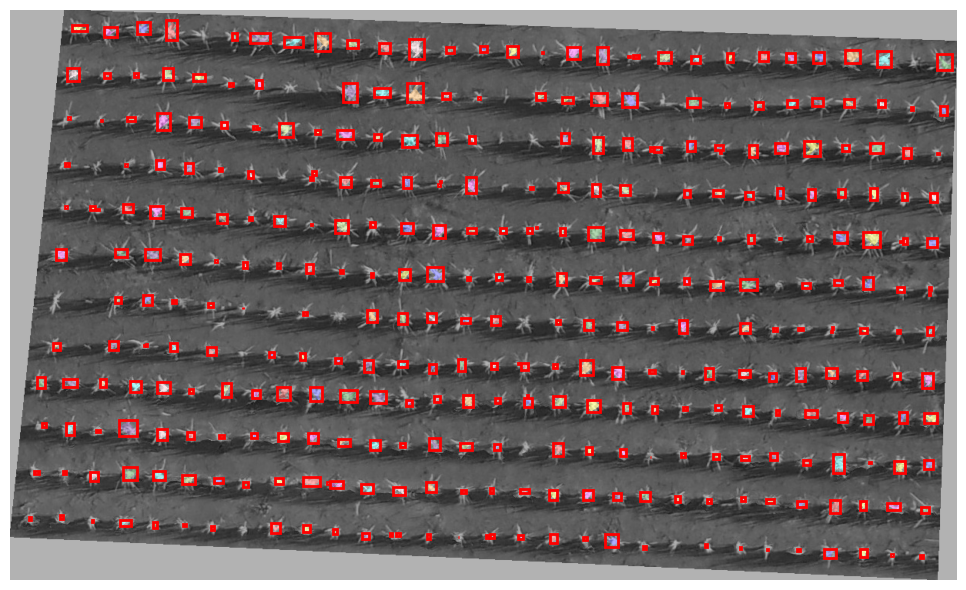

In [ ]:
image_label_overlay = label2rgb(label_image, image=img, bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 1:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

Então, com o rasterio, podemos converter o ponto central em valores de latitude e longitude:

In [ ]:
ls_x = []
ls_y = []
for region in regionprops(label_image):
    if region.area >= 1:
      y0, x0 = region.centroid
      xs, ys = rasterio.transform.xy(src.transform, y0, x0)
      ls_x.append(xs)
      ls_y.append(ys)

Criamos um DataFrame para armazenar esses valores, e depois um GeoDataFrame.

In [ ]:
df_xy = pd.DataFrame([])
df_xy['x'] = ls_x
df_xy['y'] = ls_y

In [ ]:
gdf = gpd.GeoDataFrame(df_xy, geometry=gpd.points_from_xy(df_xy['x'], df_xy['y']))

In [ ]:
gdf = gdf.set_crs(src.crs.to_dict()['init'])

Por fim, plotamos os pontos juntos com a imagem georreferênciada:

<Axes: >

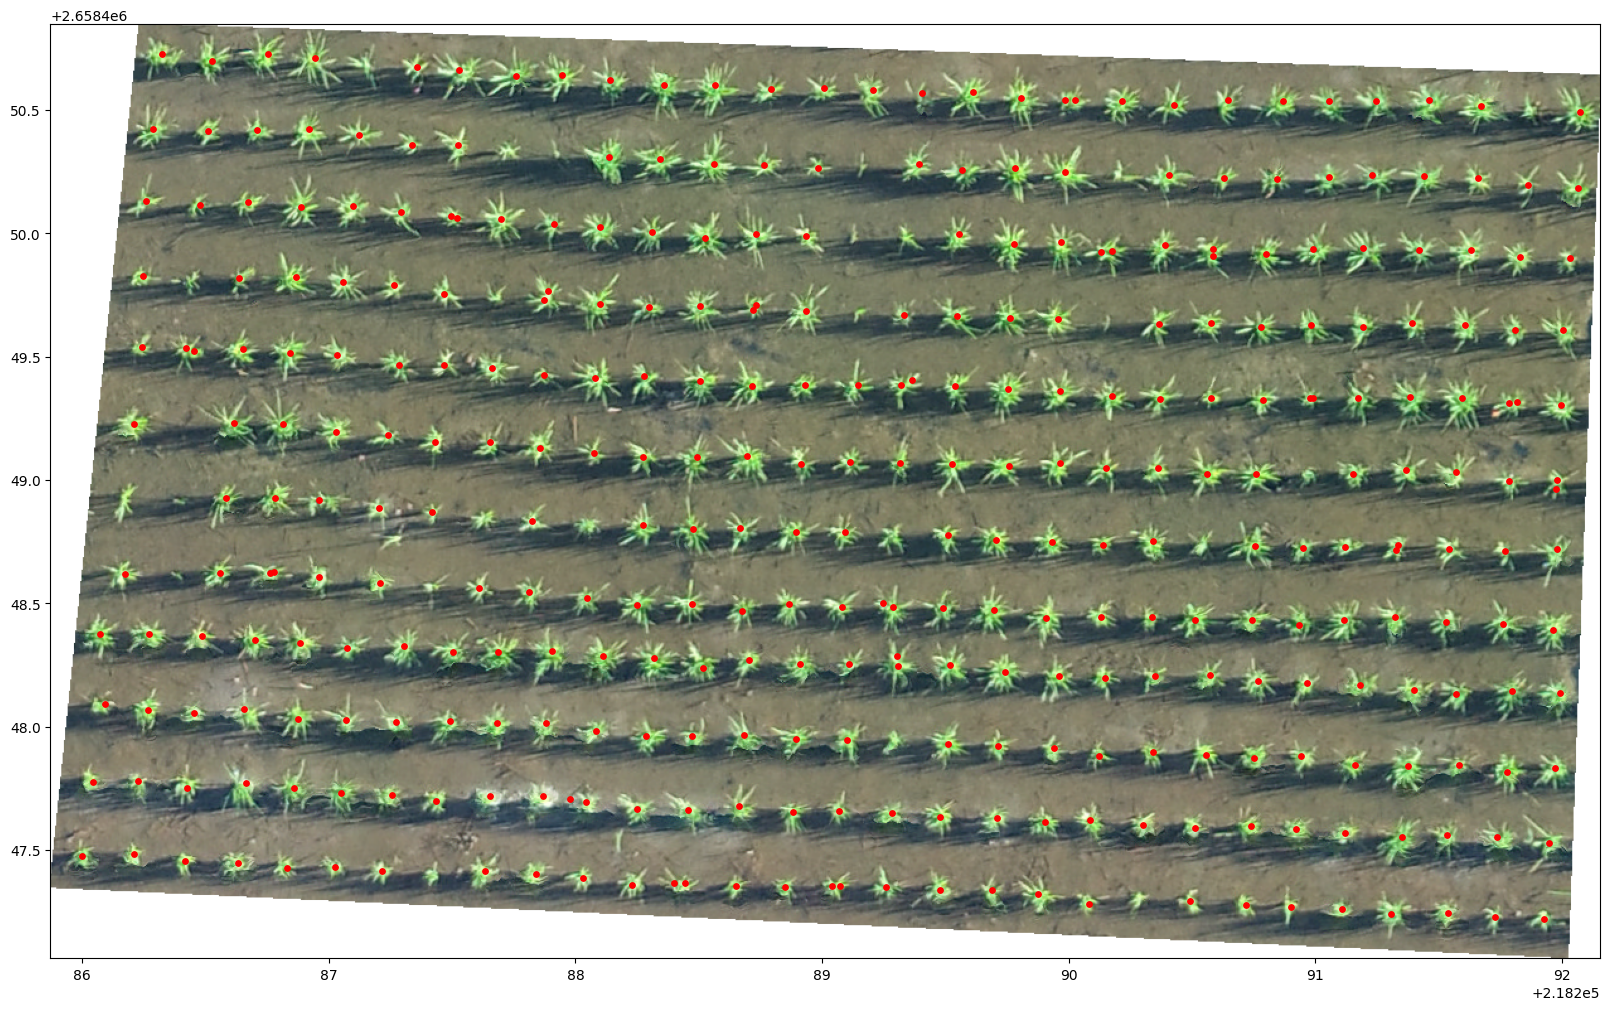

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
show((src), ax=ax)
gdf.plot(ax=ax,  marker='o', color='red', markersize=15)

Podemos salvar o arquivo em um shapefile e fazer o donwload:

In [ ]:
if not os.path.isdir('/content/shapefile'):
    os.mkdir('/content/shapefile')

In [ ]:
gdf.to_file("/content/shapefile/Plants.shp")

In [ ]:
!zip -r /content/shapefile.zip /content/shapefile
from google.colab import files
files.download("/content/shapefile.zip")

  adding: content/shapefile/ (stored 0%)
  adding: content/shapefile/Plants.prj (deflated 36%)
  adding: content/shapefile/Plants.shp (deflated 52%)
  adding: content/shapefile/Plants.cpg (stored 0%)
  adding: content/shapefile/Plants.shx (deflated 73%)
  adding: content/shapefile/Plants.dbf (deflated 61%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>